# Australia Domestic Flights

We use a database provided by the **Bureau of Infrastructure and Transport Research Economics** downloaded from https://data.gov.au/dataset/ds-dga-c5029f2a-39b3-4aef-8ae1-73e7962f6170/details

The dataset contain 11 instances:

+ City1: A city each aircraft takes-off from
+ City2: A city each aircraft lands on.
+ Month: (I couldn’t find any definitions)
+ Passenger_Trips: (I couldn’t find any definitions)
+ Aircraft_Trips: The number of flight stages. A return gflight counts as two aircraft trips.
+ Passenger_Load_Factor: The total revenue passenger kilometres performed as a percentage of the total available seat kilometres.
+ Distance_GC_(km): Great Circle Distances between 2 airports
+ RPKs: Revenue Passenger Kilometres. calculated by multiplying the number of revenue passengers travelling on each flight stage, by the distance in kilometres between the ports. the distances used are great circle kilometres.
+ ASKs: It stands for “Available Seat Kilometres”. It is calculates by multiplying the number of seats availble on each flight stage, by the distance in kilometres between the ports. The distance used are Great Circle Distances.
+ Seats: Seats available in each route in that month
+ “Flight Statge” means the operation of an aircraft from take-off to landing.

*We will answer the following questions:*

+ Most popular routes
+ Which city shows a greater growth in flights **land on**?
+ Which was the best year for the australian domestic flights?
+ New cities added in the routes.

*Potential questions.*

+ Cities that have more growth potential.
+ **Try any algorithm of time series to predict the development of the flights**


In [1]:
import scipy
from scipy import stats

#librerías necesarias:

# Data handling
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Visualization
import seaborn as sns
#import plotly.express as px
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3
from matplotlib import animation

%matplotlib inline 
pd.set_option("max_rows", None)

## Dataset

In [2]:
data = pd.read_csv('https://data.gov.au/data/dataset/c5029f2a-39b3-4aef-8ae1-73e7962f6170/resource/677d307f-6a1f-4de4-9b85-5e1aa7074423/download/dom_citypairs_web.csv').dropna()

In [3]:
data.head()

,City1,City2,Month,Passenger_Trips,Aircraft_Trips,Passenger_Load_Factor,Distance_GC_(km),RPKs,ASKs,Seats,Year,Month_num
0,ADELAIDE,ALICE SPRINGS,30682,15743,143,81.8,1316,20717788.0,25327369.0,19246,1984,1
1,ADELAIDE,BRISBANE,30682,3781,32,89.8,1622,6132782.0,6829379.0,4210,1984,1
2,ADELAIDE,CANBERRA,30682,1339,12,94.7,972,1301508.0,1374348.0,1414,1984,1
3,ADELAIDE,DARWIN,30682,3050,33,66.8,2619,7987950.0,11958009.0,4566,1984,1
4,ADELAIDE,GOLD COAST,30682,1596,16,88.5,1607,2564772.0,2898047.0,1803,1984,1


In [4]:
data.shape

(24157, 12)

In [5]:
data.dtypes

City1                     object
City2                     object
Month                      int64
Passenger_Trips            int64
Aircraft_Trips             int64
Passenger_Load_Factor     object
Distance_GC_(km)           int64
RPKs                     float64
ASKs                     float64
Seats                      int64
Year                       int64
Month_num                  int64
dtype: object

### Period Stamp

In [6]:
data['Date'] = data['Month_num'].map(str) + '/' + data['Year'].map(str) 

In [7]:
data.head()

,City1,City2,Month,Passenger_Trips,Aircraft_Trips,Passenger_Load_Factor,Distance_GC_(km),RPKs,ASKs,Seats,Year,Month_num,Date
0,ADELAIDE,ALICE SPRINGS,30682,15743,143,81.8,1316,20717788.0,25327369.0,19246,1984,1,1/1984
1,ADELAIDE,BRISBANE,30682,3781,32,89.8,1622,6132782.0,6829379.0,4210,1984,1,1/1984
2,ADELAIDE,CANBERRA,30682,1339,12,94.7,972,1301508.0,1374348.0,1414,1984,1,1/1984
3,ADELAIDE,DARWIN,30682,3050,33,66.8,2619,7987950.0,11958009.0,4566,1984,1,1/1984
4,ADELAIDE,GOLD COAST,30682,1596,16,88.5,1607,2564772.0,2898047.0,1803,1984,1,1/1984


In [8]:
data_1 = pd.to_datetime(data['Date'])
data['Date'] = pd.PeriodIndex(data_1, freq='M')
data[:5]

,City1,City2,Month,Passenger_Trips,Aircraft_Trips,Passenger_Load_Factor,Distance_GC_(km),RPKs,ASKs,Seats,Year,Month_num,Date
0,ADELAIDE,ALICE SPRINGS,30682,15743,143,81.8,1316,20717788.0,25327369.0,19246,1984,1,1984-01
1,ADELAIDE,BRISBANE,30682,3781,32,89.8,1622,6132782.0,6829379.0,4210,1984,1,1984-01
2,ADELAIDE,CANBERRA,30682,1339,12,94.7,972,1301508.0,1374348.0,1414,1984,1,1984-01
3,ADELAIDE,DARWIN,30682,3050,33,66.8,2619,7987950.0,11958009.0,4566,1984,1,1984-01
4,ADELAIDE,GOLD COAST,30682,1596,16,88.5,1607,2564772.0,2898047.0,1803,1984,1,1984-01


### Routes

In [13]:
data['Routes'] = data['City1'] + ' - ' + data['City2']

In [14]:
# Check if there are duplicated routes (ex. ADELAIDE-SYDNEY  SYDNEY-ADELAIDE)

data_2 = data[data['City1'] == 'SYDNEY']

In [19]:
data_2.groupby(['City1', 'City2']).sum()

Month  Passenger_Trips  Aircraft_Trips  \
City1  City2                                                    
SYDNEY TAMWORTH      2757434           836258           20763   
       TOWNSVILLE   14778768          3442480           29784   
       WAGGA WAGGA  16439592          4564889          159908   

                    Distance_GC_(km)          RPKs          ASKs    Seats  \
City1  City2                                                                
SYDNEY TAMWORTH                20160  2.676026e+08  4.209530e+08  1315478   
       TOWNSVILLE             664170  5.817791e+09  7.371812e+09  4362017   
       WAGGA WAGGA            161480  1.675314e+09  2.522419e+09  6873079   

                      Year  Month_num  
City1  City2                           
SYDNEY TAMWORTH     129120        416  
       TOWNSVILLE   786980       2569  
       WAGGA WAGGA  880808       2844

When we filter only by Sydney we get only 3 cities from Sydney (Wagga-Wagga, Townsville and Tamworth). That ensures our assumption that we only have the one way route in the dataset.

## Most Popular Routes

In this section we are going to explore the most popular domestic routes and how they change during the years.

### Routes through the years

Seats available in each route during the years,

In [20]:
routes = pd.DataFrame(data, columns=['Routes', 'Seats', 'Year', 'Aircraft_Trips']).fillna(0)

In [23]:
routes_1 = pd.pivot_table(routes, index= "Routes", columns = "Year", aggfunc= "sum").fillna(0)
routes_1.head()

Aircraft_Trips                                  \
Year                               1984    1985    1986    1987    1988   
Routes                                                                    
ADELAIDE - ALICE SPRINGS         1474.0  1494.0  1480.0  1533.0  1524.0   
ADELAIDE - BRISBANE               435.0   451.0   542.0   745.0   792.0   
ADELAIDE - CANBERRA               159.0   307.0   361.0   305.0   295.0   
ADELAIDE - DARWIN                 301.0   267.0   213.0   104.0   105.0   
ADELAIDE - GOLD COAST             194.0   199.0   186.0   188.0   157.0   

                                                                  ...  \
Year                        1989    1990    1991    1992    1993  ...   
Routes                                                            ...   
ADELAIDE - ALICE SPRINGS  1305.0  1469.0  1520.0  1506.0  1493.0  ...   
ADELAIDE - BRISBANE        546.0   685.0  1168.0  1257.0  1276.0  ...   
ADELAIDE - CANBERRA        286.0   306.0   697.0   746.0   769.0  ...   
ADELAIDE - DARWIN          129.0    83.0   711.0   837.0   907.0  ...   
ADELAIDE - GOLD COAST       72.0   118.0   167.0   115.0    59.0  ...   

                             Seats                                            \
Year                          2011      2012      2013       2014       2015   
Routes                                                                         
ADELAIDE - ALICE SPRINGS       0.0       0.0       0.0        0.0   134274.0   
ADELAIDE - BRISBANE       814462.0  910201.0  950848.0  1006652.0  1049675.0   
ADELAIDE - CANBERRA       246699.0  251199.0  274586.0   269940.0   250141.0   
ADELAIDE - DARWIN              0.0       0.0       0.0        0.0        0.0   
ADELAIDE - GOLD COAST     216870.0  222671.0  259878.0   277069.0   280933.0   

                                                                                
Year                           2016       2017       2018       2019      2020  
Routes                                                                          
ADELAIDE - ALICE SPRINGS   180614.0   181752.0   184095.0   194949.0   44314.0  
ADELAIDE - BRISBANE       1108481.0  1108960.0  1082136.0  1112604.0  320586.0  
ADELAIDE - CANBERRA        255714.0   283584.0   286421.0   294046.0   63143.0  
ADELAIDE - DARWIN               0.0        0.0        0.0        0.0       0.0  
ADELAIDE - GOLD COAST      280326.0   261675.0   264123.0   257489.0   58588.0  

[5 rows x 74 columns]

### Aircraft Trips


In [24]:
trips = pd.DataFrame(data, columns=['Routes', 'Aircraft_Trips', 'Year'])

Should keep the most important routes

In [29]:
imp_routes = trips.drop(['Year'], axis=1).groupby(['Routes']).sum()
imp_routes_1 = imp_routes.sort_values(by='Aircraft_Trips', ascending=False)[:10]
imp_routes_1.index

Index(['MELBOURNE - SYDNEY', 'BRISBANE - SYDNEY', 'CANBERRA - SYDNEY',
       'BRISBANE - MELBOURNE', 'ADELAIDE - MELBOURNE', 'GOLD COAST - SYDNEY',
       'ADELAIDE - SYDNEY', 'CANBERRA - MELBOURNE', 'HOBART - MELBOURNE',
       'MELBOURNE - PERTH'],
      dtype='object', name='Routes')

In [32]:
trips_1 = trips[trips['Routes'].isin(imp_routes_1.index)]
trips_1.head()

,Routes,Aircraft_Trips,Year
5,ADELAIDE - MELBOURNE,711,1984
7,ADELAIDE - SYDNEY,358,1984
15,BRISBANE - MELBOURNE,324,1984
19,BRISBANE - SYDNEY,990,1984
22,CANBERRA - MELBOURNE,323,1984


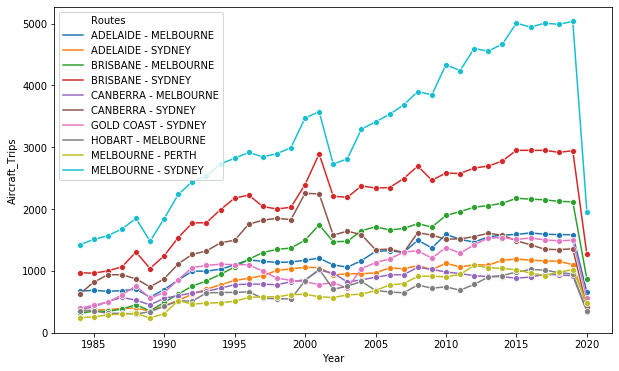

In [27]:
# Trips per year per routes

plt.figure(figsize=(10,6))
sns.lineplot(x="Year",y="Aircraft_Trips",data=trips_1,marker="o", 
                hue= "Routes",ci=None)

#### If i only consider the flights until Q3

In [37]:
time = pd.DataFrame(data, columns=['Routes', 'Aircraft_Trips', 'Year', 'Date'])
time = time[time['Routes'].isin(imp_routes_1.index)]